# COURS OPTIMISATION CONTINUE - Antonin Chambolle - 2020: Examples of stochastic algorithms : coordinate descent, gradient descent.

## Classification of handwritten digits using a "Support Vector Machine" and stochastic optimization**

Digits from the MNIST Database, [LeCun et al., 1998a: Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.]

We will show in this notebook how to solve an easy convex problems either by stochastic gradient descent or (proximal) stochastic block coordinate descent. We will address a very simplify task which is distinguishing a subset of one or several digits from another one. 

### The problem:

In practice, the learning set is made of a set of $N$ vectors $(X_i)$ (here, $28\times 28=784$ small images representing handwritten digits) and of labels $y_i\in \{-1,1\}$. (Initially, the labels are in $\{0,\dots,9\}$ and indicate the value of the handwritten digits. We define two lists "mylabelplus" and "mylabelminus" of digits, the first list will be labelled as $+1$ and the second as $-1$.)

One wants to learn a hyperplane best separating $\{X_i : y_i=+1\}$ and $\{X_i : y_i=-1\}$ in $\mathbb{R}^{784}$. That is, we want to find $(w,b)\in\mathbb{R}^{784}\times \mathbb{R}$ such that $w\cdot X_i>b$ for $y_i=1$
and $<b$ for $y_i=-1$. Assuming this is possible, to maximize the margins around this hyperplane, one solves the convex problem
$$
\min_{w,b} \sum_{i=1}^N h(y_i(w\cdot X_i-b))
$$
where $h(t) = (1-t)^+$ ("Hinge loss"). This function vanishes only if $w\cdot X_i>b+1$ each time $y_i=+1$
and $w\cdot X_i<b-1$ each time $y_i=-1$. In case one cannot find a strip (here of width $2/|w|$) separating
the positive and negative vectors, then it will try to find the hyperplane which separates, in some sense,
most vectors.

To simplify (losing a bit of precision...) here we will assume $b=0$ (in high dimension, it is not as
restrictive as it would be in low dimension), in addition, to make sure the band in between the two
sets is not too narrow, we will penalize also the size of $w$. We end up with the simpler problem:
$$
\min_{w} \frac{1}{2}|w|^2+\lambda\sum_{i=1}^N h(y_i(w\cdot X_i)). \quad (P)
$$

It is easy to find a dual of this problem, writing $h(y_i(w\cdot X_i-b))= \sup_{z_i} z_i y_i (w\cdot X_i) - h^*(z_i)$. 
We get the problem
$$
\sup_{(z_i)_{i=1}^N} \min_w \frac{1}{2}|w|^2+\lambda w\cdot \sum_{i=1}^N (z_i y_i X_i) -
\lambda \sum_{i=1}^N h^*(z_i)
= 
\sup_{(z_i)_{i=1}^N}  -\frac{1}{2}\left|\lambda \sum_{i=1}^N z_i y_i X_i\right|^2 - \lambda \sum_{i=1}^N h^*(z_i).
$$
We find as dual problem 
$$
- \lambda \min_{(z_i)_{i=1}^N} \frac{\lambda}{2}\left| \sum_{i=1}^N z_i y_i X_i\right|^2 + \sum_{i=1}^N h^*(z_i)
\quad (D)
$$
where at optimum, one recovers $w$ by letting $w  = -\lambda\sum_{i=1}^N z_i y_i X_i$. In practice,
only a fraction of the vectors appear in this sum, called the "support vectors" (this means that
most of the $(X_i)$ will live in the area where $h$ vanishes, and $z_i=0$).

Once $w$ is computed, one can evaluate on the test set how many digits are correctly labeled, by comparing the sign of $y\cdot X$ with the corresponding $y$, for $(X,y)$ from the test set.

<br>


In practice, $h(t) = (1-t)^+$ so that $h^*(s) = s$ if $s\in [-1,0]$ and $+\infty$ else. We will also used
a regularized version, as follows: for $\varepsilon>0$, we let
$h_{\varepsilon}^*(s) = s + \varepsilon s^2/2$ for $s\in [-1,0]$ and $+\infty$ else. Show in this case that
$h_\varepsilon'$ is $1/\varepsilon$ Lipschitz and that:
$$
h_\varepsilon(t) = \begin{cases} 1-t-\frac{\varepsilon}{2} & \text{ if } t\le 1-\varepsilon \\
\frac{(t-1)^2}{2\varepsilon} & \text{ if } 1-\varepsilon \le t \le 1 \\
0 & \text{ if } t\ge 1
\end{cases}\quad ,\quad
h'_\varepsilon(t) = \begin{cases} -1 & \text{ if } t\le 1-\varepsilon \\
\frac{t-1}{\varepsilon} & \text{ if } 1-\varepsilon \le t \le 1 \\
0 & \text{ if } t\ge 1
\end{cases}
$$
We will normalize the images so that $|X_i|=1$. In the dual problem we find that the derivative of the quadratic term of energy with respect to $z_i$ is $1$-Lipschitz. 
In the primal problem, if we replace $h$ with $h_\varepsilon$, we find that the Lipschitz constant of
the gradient of the objective (which is now $C^1$) with respect to $w$ is at most $1+\lambda/\varepsilon$.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gzip

First, we download the MNIST database. We used the .csv files in https://www.python-course.eu/neural_network_mnist.php
and then installed these in the directory data/mnist/: please adapt the code by setting the variable data_path below accordingly. The code in the next cell is copy-pased from the above link.

In [2]:
# Load MNIST data 

# training data
mnist_path = "data/mnist/"
train_images_path = mnist_path+"train-images-idx3-ubyte.gz"
with gzip.open(train_images_path, 'rb') as train_imgpath:
    train_imgs = np.frombuffer(train_imgpath.read(), dtype=np.uint8,
                                 offset=16).reshape(-1, 784)/255.0
    
train_labels_path = mnist_path+"train-labels-idx1-ubyte.gz"
with gzip.open(train_labels_path, 'rb') as train_lbpath:
    train_labels = np.frombuffer(train_lbpath.read(), dtype=np.uint8,
                                 offset=8)
    
# test data
test_images_path = mnist_path+"t10k-images-idx3-ubyte.gz"
with gzip.open(test_images_path, 'rb') as test_imgpath:
    test_imgs = np.frombuffer(test_imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(-1, 784)/255.0
    
test_labels_path = mnist_path+"t10k-labels-idx1-ubyte.gz"
with gzip.open(test_labels_path, 'rb') as test_lbpath:
    test_labels = np.frombuffer(test_lbpath.read(), dtype=np.uint8,
                                offset=8)
# remove spurious dimensions
train_labels=np.squeeze(train_labels)
test_labels=np.squeeze(test_labels)

In [4]:
# reduce the size of train set if needed
# this might be necessary for the random coordinate ascent which starts 
# by computing a N*N matrix of scalar products. We convert before this the
# values to float32 (4 bytes), yet N=60000 values (the size of the training set)
# require 14.4 Gb
# depending on the number of figures selected below and your memory you should
# adjust the value of r (the coordinate descent on the primal does not need this)
# (the speed of your processor can also be a bottleneck, computing the matrix is best
# with many cores)

r = 60/100 # 30% 

indices = (np.random.random(train_labels.shape)<r)
train_labels = train_labels[indices]
train_imgs = train_imgs[indices,:]

In the next cell, we define the digits we want to label as +1 and the digit labelled as -1 (first arrays).
Then we extract from the database the $X_i$ (array mytri), the $y_i$ (array mytrls). We do the same for
the test set.

In [5]:
mylabelsplus = np.array([9,1,6],dtype=float)
#mylabelsminus = np.array([0,2,3,4,5,6,7,8,9],dtype=float)
mylabelsminus = np.array([3,7,4,8],dtype=float)

# extract the labels of interest
indicesp = np.zeros(train_labels.shape,dtype=bool)
indicesm = np.zeros(train_labels.shape,dtype=bool)
for l in mylabelsplus:
    indicesp = np.logical_or(indicesp,train_labels==l)
for l in mylabelsminus:
    indicesm = np.logical_or(indicesm,train_labels==l)
indices = np.logical_or(indicesm,indicesp)
#indices = np.logical_or(train_labels==mylabels[0],train_labels==mylabels[1])

mytrl = train_labels[indices]
mytri = train_imgs[indices,:]
mytrls = np.empty(mytrl.shape, dtype=np.int8)
mytrls[indicesp[indices]] = 1
mytrls[indicesm[indices]] = -1

# same for test
indicesp = np.zeros(test_labels.shape,dtype=bool)
indicesm = np.zeros(test_labels.shape,dtype=bool)
for l in mylabelsplus:
    indicesp = np.logical_or(indicesp,test_labels==l)
for l in mylabelsminus:
    indicesm = np.logical_or(indicesm,test_labels==l)
indices = np.logical_or(indicesm,indicesp)
#indices = np.logical_or(test_labels==mylabels[0],test_labels==mylabels[1])

mytel = test_labels[indices]
mytei = test_imgs[indices,:]
mytels = np.empty(mytel.shape, dtype=np.int8)
mytels[indicesp[indices]] = 1
mytels[indicesm[indices]] = -1

# we normalize the l2 norm of the X's to 1. This is interesting as it makes the quadratic
# term in the dual problem have a lambda-Lipschitz derivative wr z_i
mytri = np.divide(mytri,np.reshape(np.linalg.norm(mytri,axis=1),(-1,1)))
mytei = np.divide(mytei,np.reshape(np.linalg.norm(mytei,axis=1),(-1,1)))


[1 3 1 4 3 8 6 9 9 1]


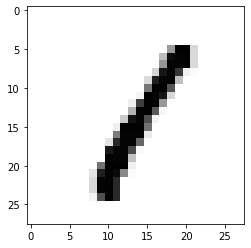

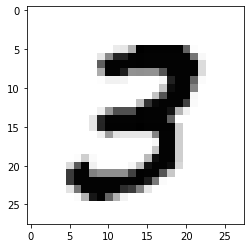

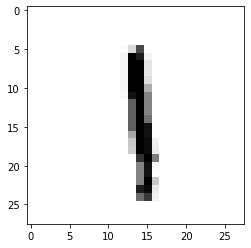

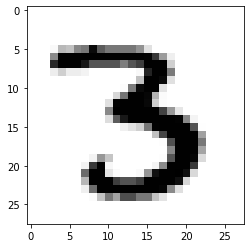

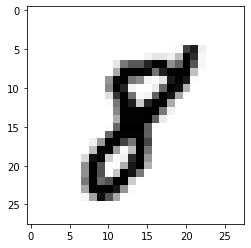

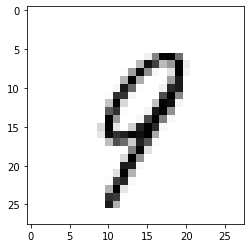

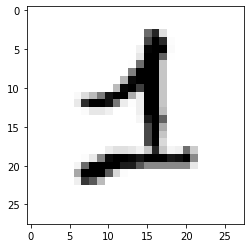

In [6]:
# show some images
print(mytrl[0:10])
for i in range(10):
    img = mytri[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

We consider the primal problem, with regularized $h_\varepsilon$, which we write:
$$
\min_{w}\sum_{i=1}^N \frac{1}{2N}|w|^2+ \lambda h_\varepsilon(y_i(w\cdot X_i)). \quad (P)
$$
and letting $f_i(w):= |w|^2/(2N) +  \lambda h_\varepsilon(y_i(w\cdot X_i))$ we will implement a randomized 
gradient descent, updating at each iteration $w^{k+1} = w^k -\tau \nabla f_i(w^k)$ for a randomly
chosen $i$, and $\tau \to 0$ (or $\tau \sim 1/\sqrt{\mbox{number of iterations}}$).

One has
$$
\nabla f_i (w) = \frac{w}{N} +  \lambda h'_\varepsilon(y_i(w\cdot X_i)) y_i X_i
$$

In [7]:
# randomized coordinate descent on the primal

print('solving a SVM by randomized gradient descent')
print('to classify digits ', mylabelsplus ,' and ',mylabelsminus ,' from the MNIST database')

N= mytrl.shape[0] # number of elements
epoch = 20 # number of "epochs" (= iterations / N)

w = np.zeros(mytri.shape[1]) # initial w
lbda = 1

random.seed()

# "Huber" type regularization for (1-t)^+ (epsilon 1 works)
epsilon = .5 
# step for gradient descent
le = epsilon/(epsilon+lbda) * 10 / np.sqrt(N*epoch)

def dh(x):
    global epsilon
    if x < 1-epsilon:
        return -1
    elif x < 1:
        return (x-1)/epsilon
    else:
        return 0

for it in range(epoch*N):
    i = random.randint(0,N-1)
    gra = w/N + mytrls[i]*mytri[i,:]*dh(mytrls[i]*np.dot(mytri[i,:],w))
    w = w - le * gra
    
print('done')

solving a SVM by randomized gradient descent
to classify digits  [9. 1. 6.]  and  [3. 7. 4. 8.]  from the MNIST database
done


 train success =  [90.2] %
 fail =  [9.8] %
 test success =  [90.18] %
 fail =  [9.82] %


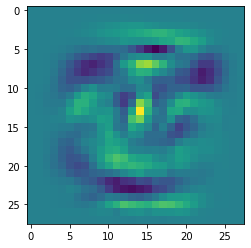

In [8]:
# now we test the results
succeed = (np.sum(mytrls * (mytri @ w) >= 0)) # if y_i and w.X_i have same sign then the classification is correct
total = (mytrls.shape)

print(' train success = ',np.round(100*succeed/total,2),'%\n fail = ',np.round(100*(total-succeed)/total,2),'%')

succeed = (np.sum(mytels * (mytei @ w) >= 0))
total = (mytels.shape)

print(' test success = ',np.round(100*succeed/total,2),'%\n fail = ',np.round(100*(total-succeed)/total,2),'%')

img = w.reshape((28,28))
plt.imshow(img)
plt.show()

Now, we try a different algorithm, that is, a stochastic coordinate ascent on the dual problem. We will even try a proximal coordinate ascent, which is shown to converge in [Peter Richtárik and Martin Takáč. Iteration complexity of randomized block-coordinate descent methods for minimizing a composite function. Math. Program., 144(1-2, Ser. A):1–38, 2014.]

The problem is:
$$
- \lambda \min_{(z_i)_{i=1}^N} \frac{\lambda}{2}\left| \sum_{i=1}^N z_i y_i X_i\right|^2 + \sum_{i=1}^N h^*(z_i)
\quad (D)
$$
Now, the gradient wr $z_i$ of the quadratic term is given by
$$
g_i(z):=\lambda y_i\sum_{j=1}^N z_j y_j (X_i\cdot X_j)
$$
so that, in order to solve the problem, one should compute all the scalar products $X_i\cdot X_j$ (on the
other hand observe that it is the only information we need about the $X_i$'s to solve this problem, which 
will allow to replace this scalar product by arbitrary kernels $k(X_i,X_j)$, in more efficient "kernel-SVM"
methods).

The Lipschitz constant of this expression with respect to $z_i$ is $\lambda y_i^2 |X_i|^2=\lambda$. One
should therefore take a step $\tau=1/\lambda$.
Then, the optimization consists in picking randomly $i$ and updating $z_i^{k+1}=
\text{prox}_{\tau h^*} (z^k_i- \tau g_i(z^k))$. Here for $\varepsilon \ge 0$,
$$
\text{prox}_{\tau h_\varepsilon^*} (t) = \max\left\{\min\left\{ \frac{t-\tau}{1+\epsilon\tau}, 0\right\}, -1\right\}
$$


In [10]:
N = mytrl.shape[0]
epoch = 30

z = np.zeros(N)

print('computing',N*N,'scalar products')
# reduce the size of array (float64 is too large for 60000 images, even 32)
mytri = np.float32(mytri)
scapro = mytri @ np.transpose(mytri) ## this is a bottleneck for too large arrays
print('done')

import random
random.seed()

# step for gradient descent
lbda = 1
tau = 1/lbda
epsilon = 0

# randomized coordinate descent on the dual

print('solving a SVM by randomized coordinate ascent on the dual')
print('to classify digits ',mylabelsminus,' and ',mylabelsplus,' from the MNIST database')

for it in range(epoch*N):
    i = random.randint(0,N-1)
    gra = lbda*mytrls[i]*np.sum(z*scapro[i,:]*mytrls)
    z[i] = np.minimum(np.maximum(z[i]-tau*gra - tau,-1),0)/(1+tau*epsilon) # the prox

# compute finally w

w = -np.sum(np.reshape(z*mytrls,(-1,1))*mytri,axis=0)

print('done')

computing 648160681 scalar products
done
solving a SVM by randomized coordinate ascent on the dual
to classify digits  [3. 7. 4. 8.]  and  [9. 1. 6.]  from the MNIST database
done


 train success =  [91.3] %
 fail =  [8.7] %
 test success =  [90.81] %
 fail =  [9.19] %


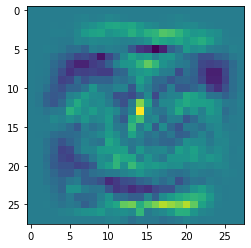

In [11]:
# now we test the results
succeed = (np.sum(mytrls * (mytri @ w) >= 0)) # if y_i and w.X_i have same sign then the classification is correct
total = (mytrls.shape)

print(' train success = ',np.round(100*succeed/total,2),'%\n fail = ',np.round(100*(total-succeed)/total,2),'%')

succeed = (np.sum(mytels * (mytei @ w) >= 0))
total = (mytels.shape)

print(' test success = ',np.round(100*succeed/total,2),'%\n fail = ',np.round(100*(total-succeed)/total,2),'%')

img = w.reshape((28,28))
plt.imshow(img)
plt.show()

In [19]:
train_imgs.shape

(17942, 784)